In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance
from gudhi import bottleneck_distance

def analyze_persistence_series(price_series, policy_data, policy_columns, 
                                lag_dim=5, window_size=30, max_edge_length=50.0, verbose=True):
    import numpy as np
    import pandas as pd
    import gudhi as gd
    from tqdm import tqdm
    if isinstance(price_series, np.ndarray):
        price_series = pd.Series(price_series)
    # 滞后价格特征（price[t-1] 到 price[t-lag_dim]）
    price_lags = np.vstack([
        price_series[i:-(lag_dim + 1 - i)] for i in range(1, lag_dim + 1)
    ]).T

    # 当前价格（price[t]，从 lag_dim 开始）
    price_current = price_series[lag_dim:].reset_index(drop=True)[:len(price_lags)].values.reshape(-1, 1)

    # 当前政策变量（policy[t]，从 lag_dim 开始）
    policy_used = policy_data[policy_columns]
    policy_current = policy_used.iloc[lag_dim:lag_dim + len(price_lags)].reset_index(drop=True)

    # 合并为高维点云：[price[t], price[t-1:t-5], policy[t]]
    cloud = np.hstack([price_current, price_lags, policy_current.values])
    dates = policy_data["Date"].iloc[lag_dim:lag_dim + len(price_lags)].reset_index(drop=True)

    # 计算H0/H1的L1/L2范数
    def compute_persistence_norms(cloud_slice):
        rips = gd.RipsComplex(points=cloud_slice, max_edge_length=max_edge_length)
        st = rips.create_simplex_tree(max_dimension=2)
        persistence = st.persistence()
        h1_l1 = h1_l2 = h0_l1 = h0_l2 = 0
        for dim, (birth, death) in persistence:
            if not np.isfinite(death): continue
            life = death - birth
            if dim == 1:
                h1_l1 += life
                h1_l2 += life ** 2
            elif dim == 0:
                h0_l1 += life
                h0_l2 += life ** 2
        return {
            "H1_L1": h1_l1,
            "H1_L2": np.sqrt(h1_l2),
            # "H0_L1": h0_l1,
            # "H0_L2": np.sqrt(h0_l2),
        }

    def get_h1_diagram(cloud_slice):
        rips = gd.RipsComplex(points=cloud_slice, max_edge_length=max_edge_length)
        st = rips.create_simplex_tree(max_dimension=2)
        diag = st.persistence()
        return np.array([pair[1] for pair in diag if pair[0] == 1 and np.isfinite(pair[1][1])])

    # 滑动窗口计算范数 & diagram
    norms, diagrams = [], []
    iterator = tqdm(range(len(cloud) - window_size)) if verbose else range(len(cloud) - window_size)
    for i in iterator:
        subcloud = cloud[i:i+window_size]
        norms.append(compute_persistence_norms(subcloud))
        diagrams.append(get_h1_diagram(subcloud))

    return pd.DataFrame(norms), diagrams, dates[window_size:]

100%|███████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 373.43it/s]


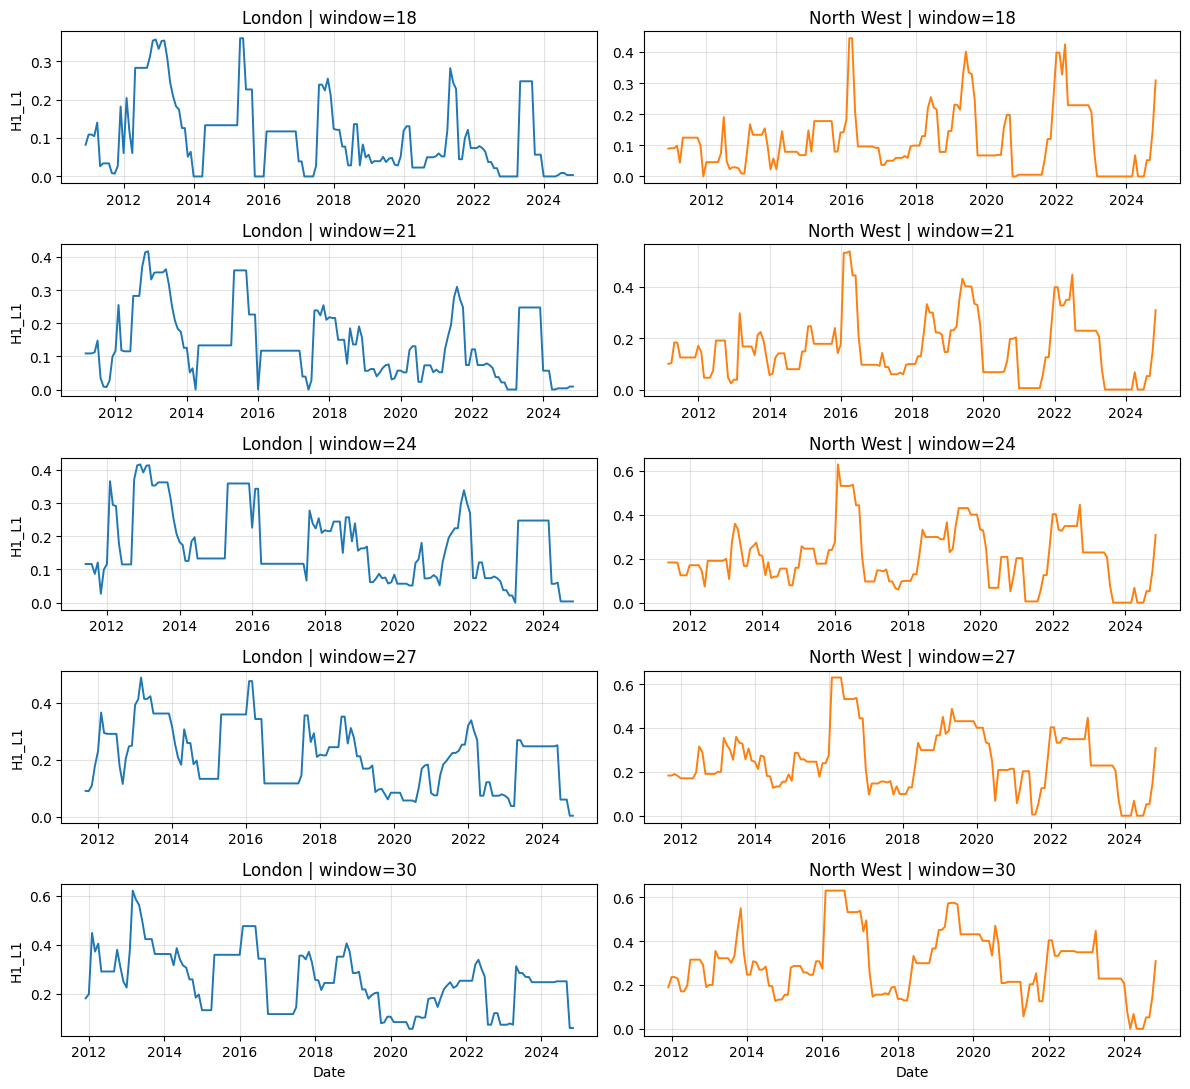

In [5]:
def robustness_check_and_plot_two_regions(
    df_left, name_left,
    df_right, name_right,
    policy_columns,
    lag_dim=5,
    window_sizes=(18,21,24,27,30),
    max_edge_length=50.0,
    verbose=True,
    plot_metric="H1_L1"
):

    price_left = df_left["Average_Housing_Price"].values
    price_right = df_right["Average_Housing_Price"].values
    
    def compute_results(price_series, policy_df):
        results = []
        for ws in window_sizes:
            norms_df, diagrams, dates_aligned = analyze_persistence_series(
                price_series=price_series,
                policy_data=policy_df,
                policy_columns=policy_columns,
                lag_dim=lag_dim,
                window_size=ws,
                max_edge_length=max_edge_length,
                verbose=verbose
            )
            dates_aligned = pd.to_datetime(dates_aligned).reset_index(drop=True)
            results.append((ws, norms_df, dates_aligned))
        return results

    left_results = compute_results(price_left, df_left)
    right_results = compute_results(price_right, df_right)

    nrows = len(window_sizes)
    fig, axes = plt.subplots(nrows, 2, figsize=(12, max(2.2*nrows, 6)), sharex=False)
    if nrows == 1:
        axes = np.array([axes])  # 保证二维索引

    for r, ws in enumerate(window_sizes):
        # London-Left
        ws_l, norms_l, dates_l = left_results[r]
        if plot_metric not in norms_l.columns:
            raise ValueError(f"{name_left} 缺少列 {plot_metric}，可用列：{list(norms_l.columns)}")
        y_l = norms_l[plot_metric].values
        m_l = min(len(y_l), len(dates_l))
        axes[r, 0].plot(dates_l.iloc[:m_l], y_l[:m_l], lw=1.4)
        axes[r, 0].set_title(f"{name_left} | window={ws_l}")
        axes[r, 0].set_ylabel(plot_metric)
        axes[r, 0].grid(True, alpha=0.35)

        # North West-Right
        ws_r, norms_r, dates_r = right_results[r]
        if plot_metric not in norms_r.columns:
            raise ValueError(f"{name_right} 缺少列 {plot_metric}，可用列：{list(norms_r.columns)}")
        y_r = norms_r[plot_metric].values
        m_r = min(len(y_r), len(dates_r))
        axes[r, 1].plot(dates_r.iloc[:m_r], y_r[:m_r], lw=1.4, color='tab:orange')
        axes[r, 1].set_title(f"{name_right} | window={ws_r}")
        axes[r, 1].grid(True, alpha=0.35)

    axes[-1, 0].set_xlabel("Date")
    axes[-1, 1].set_xlabel("Date")

    fig.tight_layout()
    plt.show()


# ===== 使用示例 =====
# 读入两个地区的数据
df_l = pd.read_csv("London_Housing_Policy_Dataset_sd.csv", parse_dates=["Date"])
df_r = pd.read_csv("North_West_Housing_Policy_Dataset_sd.csv", parse_dates=["Date"])

policy_columns = ['Weekly_Earnings','Employment_Rate','Benefit Caseload',
                  'Housing Supply','Euro Rate','Interest Rate']

robustness_check_and_plot_two_regions(
    df_left=df_l, name_left="London",
    df_right=df_r, name_right="North West",
    policy_columns=policy_columns,
    lag_dim=5, window_sizes=(18,21,24,27,30),
    max_edge_length=50.0, verbose=True,
    plot_metric="H1_L1"
)


100%|███████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 697.14it/s]


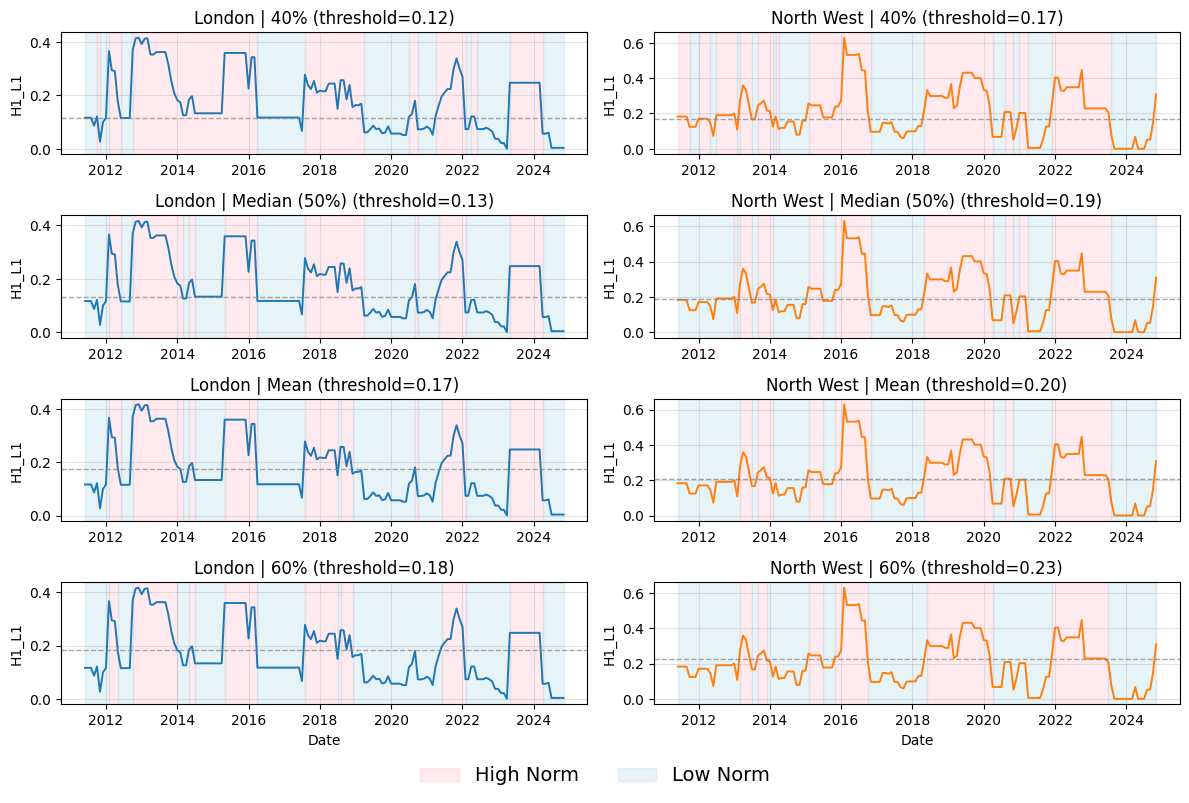

In [20]:
def quantile_threshold_plot_two_regions(
    df_left, name_left,
    df_right, name_right,
    policy_columns,
    lag_dim=5, window_size=24, max_edge_length=50.0,
    verbose=True, plot_metric="H1_L1"
):
    """
    在同一张图上对两个地区做阈值稳健性检验：
    4 行（40% / Median / Mean / 60%） × 2 列（左：left地区，右：right地区）
    """

    def compute_series(df):
        price_series = df["Average_Housing_Price"].values
        norms_df, diagrams, dates_aligned = analyze_persistence_series(
            price_series=price_series,
            policy_data=df,
            policy_columns=policy_columns,
            lag_dim=lag_dim,
            window_size=window_size,
            max_edge_length=max_edge_length,
            verbose=verbose
        )
        dates_aligned = pd.to_datetime(dates_aligned).reset_index(drop=True)
        if plot_metric not in norms_df.columns:
            raise ValueError(f"{plot_metric} 不在结果列中，可用列：{list(norms_df.columns)}")
        y = norms_df[plot_metric].values
        m = min(len(y), len(dates_aligned))
        return y[:m], dates_aligned.iloc[:m]

    # 计算两地区数据
    y_l, dates_l = compute_series(df_left)
    y_r, dates_r = compute_series(df_right)

    # 阈值集合（各自单独计算）
    thresholds_left = [
        ("40%",  np.quantile(y_l, 0.40)),
        ("Median (50%)", np.quantile(y_l, 0.50)),
        ("Mean", np.mean(y_l)),
        ("60%",  np.quantile(y_l, 0.60)),
    ]
    thresholds_right = [
        ("40%",  np.quantile(y_r, 0.40)),
        ("Median (50%)", np.quantile(y_r, 0.50)),
        ("Mean", np.mean(y_r)),
        ("60%",  np.quantile(y_r, 0.60)),
    ]

    # 绘制 4×2
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharex=False)

    def shade_and_plot(ax, dates, y, threshold, title_suffix, line_color):
        above = y > threshold
        current_state = above[0]
        start_idx = 0
        for i in range(1, len(y)):
            if above[i] != current_state:
                ax.axvspan(dates.iloc[start_idx], dates.iloc[i],
                           color=("pink" if current_state else "lightblue"), alpha=0.3)
                start_idx = i
                current_state = above[i]
        # 最后一段
        ax.axvspan(dates.iloc[start_idx], dates.iloc[len(y)-1],
                   color=("pink" if current_state else "lightblue"), alpha=0.3)

        ax.plot(dates, y, lw=1.4, color=line_color)
        ax.axhline(threshold, color="gray", linestyle="--", lw=1, alpha=0.7)
        ax.set_title(title_suffix)
        ax.set_ylabel(plot_metric)
        ax.grid(True, alpha=0.35)

    # 逐行绘制
    row_titles = ["40%", "Median (50%)", "Mean", "60%"]
    legend_elements = [
        Patch(facecolor='pink', edgecolor='pink', alpha=0.3, label='High Norm'),
        Patch(facecolor='lightblue', edgecolor='lightblue', alpha=0.3, label='Low Norm')
    ]

    for r in range(4):
        label_l, thr_l = thresholds_left[r]
        label_r, thr_r = thresholds_right[r]

        # 左列：London → 蓝色线
        shade_and_plot(
            axes[r, 0], dates_l, y_l, thr_l,
            f"{name_left} | {row_titles[r]} (threshold={thr_l:.2f})",
            line_color="tab:blue"
        )
        # 右列：North West → 橙色线
        shade_and_plot(
            axes[r, 1], dates_r, y_r, thr_r,
            f"{name_right} | {row_titles[r]} (threshold={thr_r:.2f})",
            line_color="tab:orange"
        )

    axes[-1, 0].set_xlabel("Date")
    axes[-1, 1].set_xlabel("Date")
    fig.legend(handles=legend_elements,
               loc="lower center",    # 放在图底部中间
               bbox_to_anchor=(0.5, -0.01),  # 向下稍微移动
               ncol=2,                # 横向排布两个
               frameon=False,fontsize=14)

    fig.tight_layout(rect=[0, 0.04, 1, 1])  # 给底部留白
    plt.show()


# ===== 使用示例 =====
df_l = pd.read_csv("London_Housing_Policy_Dataset_sd.csv", parse_dates=["Date"])
df_r = pd.read_csv("North_West_Housing_Policy_Dataset_sd.csv", parse_dates=["Date"])

policy_columns = ['Weekly_Earnings','Employment_Rate','Benefit Caseload',
                  'Housing Supply','Euro Rate','Interest Rate']

quantile_threshold_plot_two_regions(
    df_left=df_l,  name_left="London",
    df_right=df_r, name_right="North West",
    policy_columns=policy_columns,
    lag_dim=5, window_size=24, max_edge_length=50.0,
    verbose=True, plot_metric="H1_L1"
)
